In [30]:
# External libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import requests

# helpful check routine
def is_downloadable(url):
    """
    Does the url contain a downloadable resource
    """
    h = requests.head(url, allow_redirects=True)
    header = h.headers
    content_type = header.get('content-type')
    if 'text' in content_type.lower():
        return False
    if 'html' in content_type.lower():
        return False
    return True

In [31]:
# CSI routines
import csi.planarfault as pf
import csi.gps as gr
import csi.insar as insar
import csi.geodeticplot as geoplt
import csi.seismiclocations as sl
import csi.imagedownsampling as imagedownsampling
import csi.fault3D as flt3D
import csi.faultwithvaryingdip as flt
import csi.verticalfault as verticalfault
#import csi.cosicorrrates as cr
import csi.imagecovariance as imcov


The first part of this script repeats some of the initial setup that is in the covarSAR notebook, but here we will be doing the downsampling. The `input_check` flag is turned off as it was likely run before, and we are assuming the covariance estimation was already done.

In [32]:
# set some flags
input_check = False
do_covar = False
do_downsample = True
output_check = True

CSI does most computations in a local Cartesian coordinate system. It presently supports only UTM projections, so we need to set the zone to use and the local center.

In [33]:
# UTM zone 11 for eastern California
utmzone = 11
# center for local coordinates--M7.1 epicenter from Zach Ross catalog
lon0 = -117.5995
lat0 = 35.7678

For this example, we will use an InSAR dataset for the 2019 Ridgecrest earthquake, published online at the Harvard Dataverse:

Fielding, Eric Jameson, 2019, "Replication Data for: Surface deformation related to the 2019 Mw 7.1 and Mw 6.4 Ridgecrest Earthquakes in California from GPS, SAR interferometry, and SAR pixel offsets", https://doi.org/10.7910/DVN/JL9YMS, Harvard Dataverse, V2

The dataset we will work with is an ALOS-2 wide-swath interferogram from descending track 166.

The fastest way to get the datasets from the Harvard Dataverse is to go to the DOI URL listed above that will redirect to the actual Dataverse site: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JL9YMS

In the search box, you can search for "*D166*" (without the quotes but including the asterisks) to find the files for the D166 track. Select all the files and then the `download` button will download a zip file of the files, or you can download each file separately. The data files are about 93 MB each because the ALOS-2 ScanSAR interferogram is about 350 by 350 km. There are four data files and a map figure from the SRL article that is embedded below. The map shows the interferogram range change in the area of Ridgecrest coseismic rupture  that is a small part of the full interferogram.
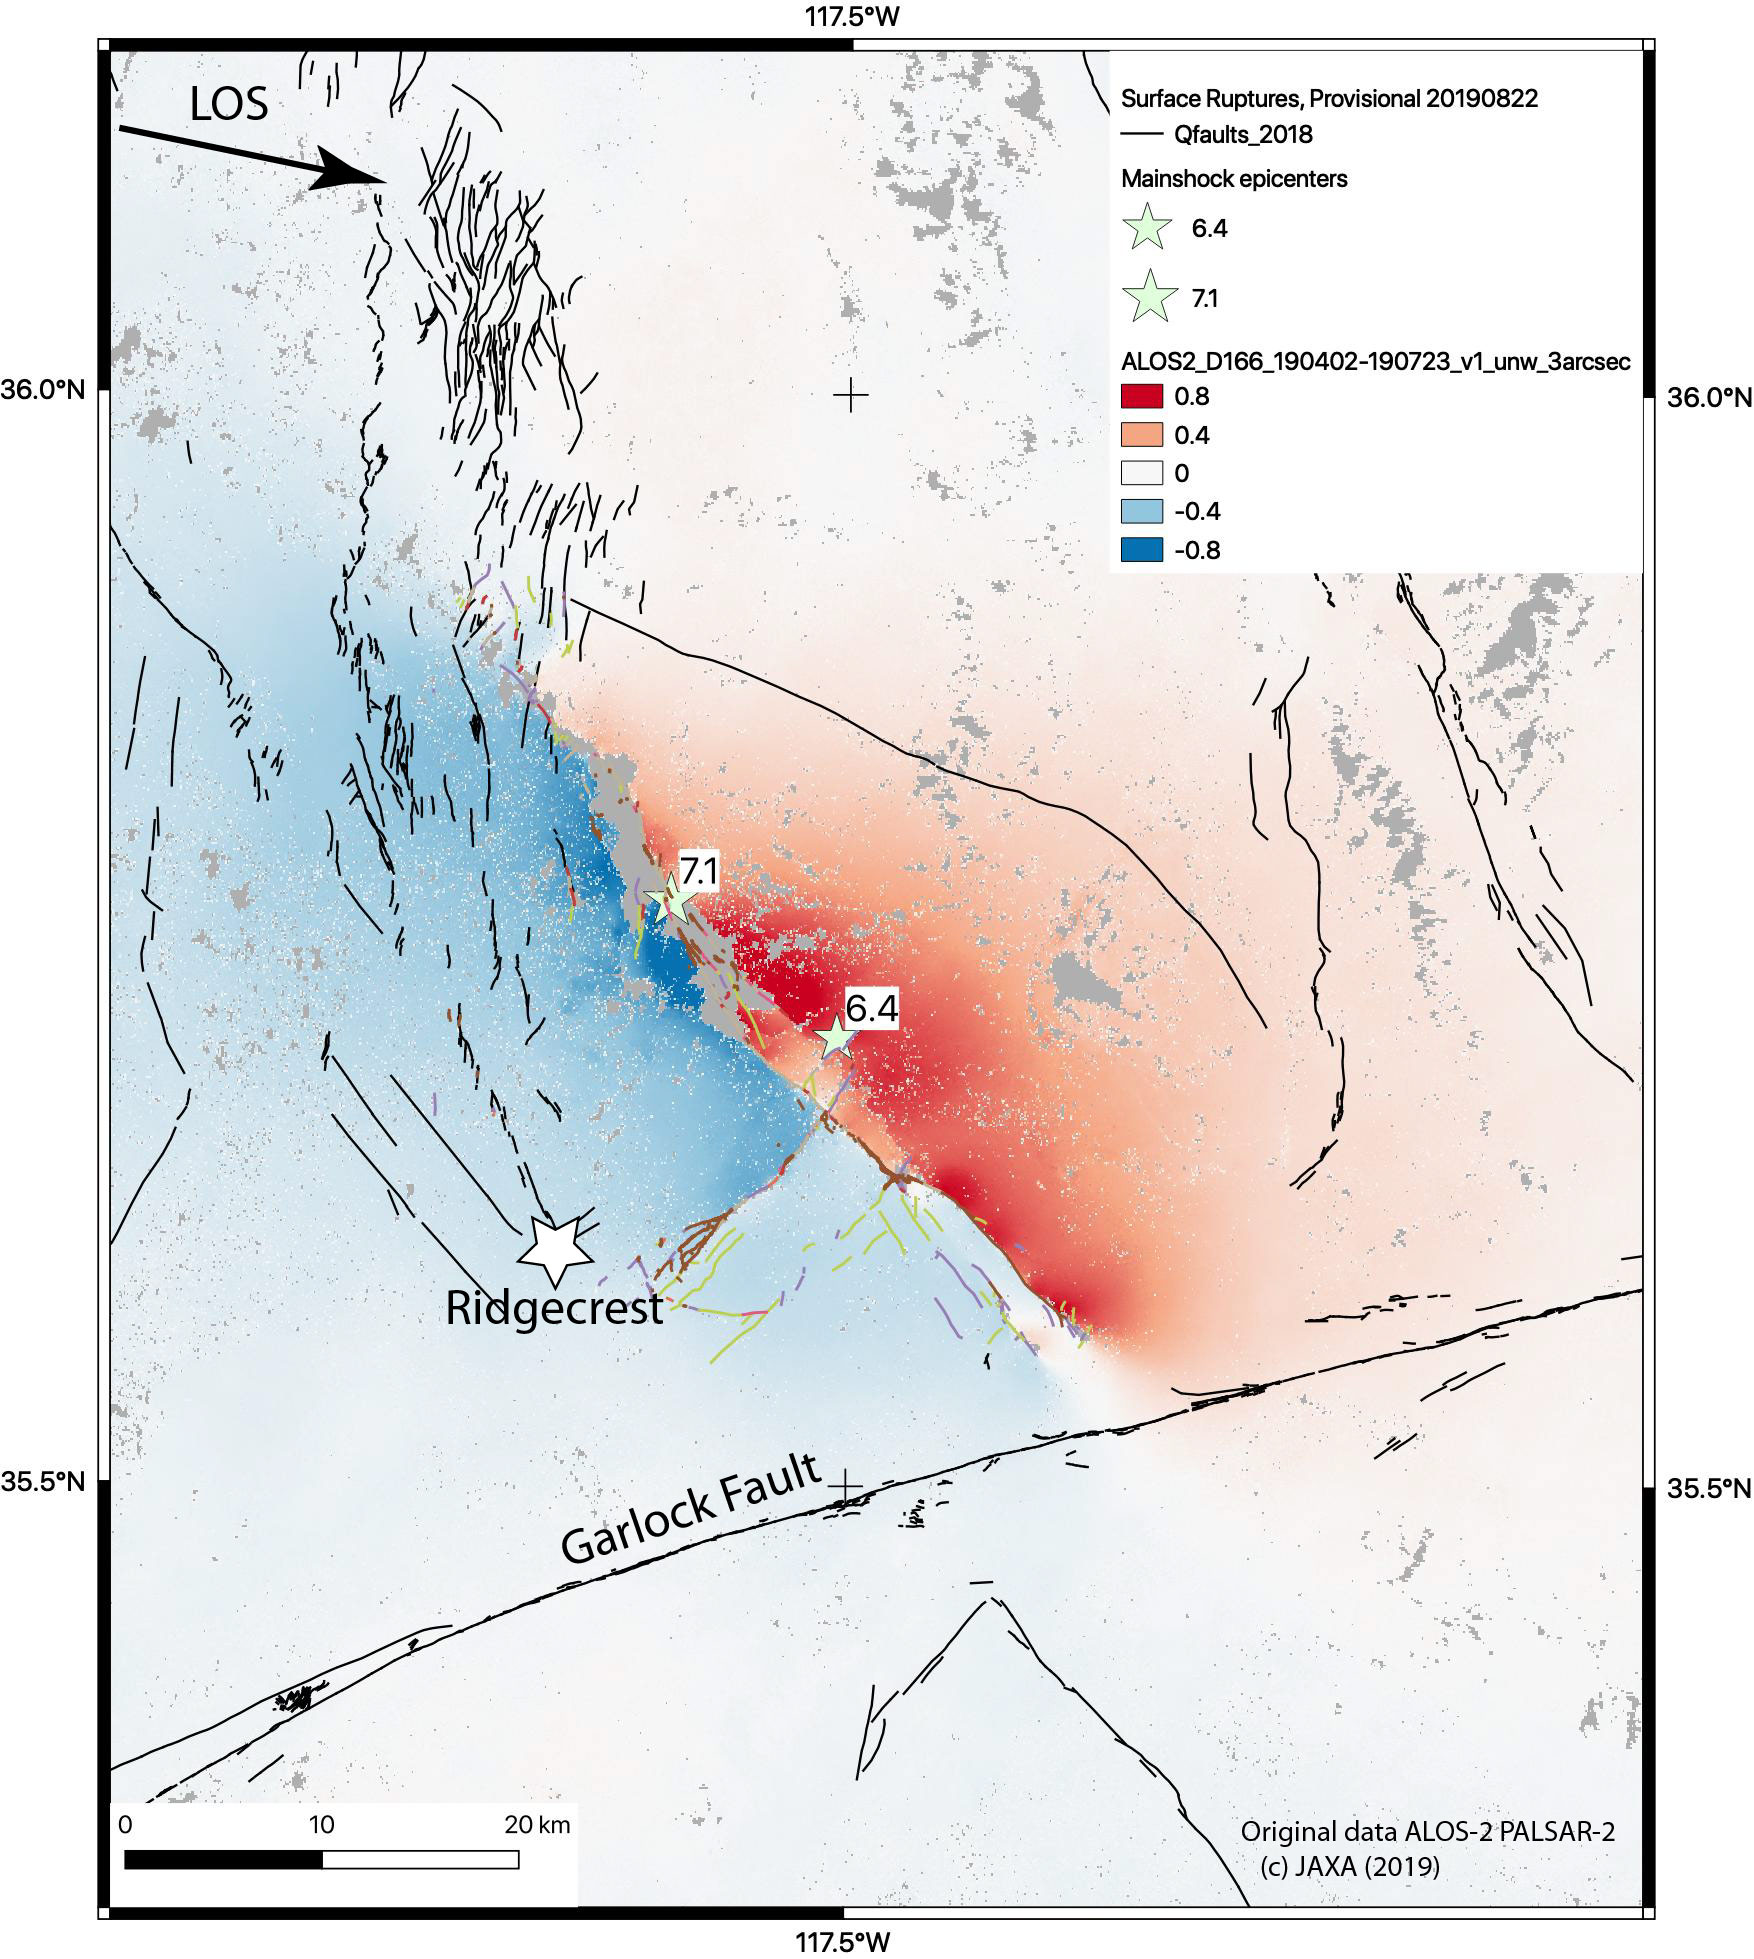

We set the output name for the dataset below.

In [34]:
# set the output name root
outName = 'A2D166'  # ALOS-2 Descending track 166

The range-change file is the interferogram converted to range-change in meters and this range-change file has already been masked to remove areas of low coherence (gray in the above map). We can use the `requests` library to download the file to the local directory from Python (if you did not click on the links at the main Dataverse URL above which is faster). The code below will download the file if it does not already exist in the directory.

In [35]:
# range-change file name locally
d166_rng='ALOS2_D166_190402-190723_v1_range_change_m_3arcsec.grd'
if os.path.exists(d166_rng) == False:   # if the file not here yet
    # store direct download url of range-change dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/GDQUXT'
    if is_downloadable(url): # does URL point to a file?
        # Download data into a requests variable with the above url
        r = requests.get(url, allow_redirects=True)
        # Write the content of above request variable to the file name
        open(d166_rng, 'wb').write(r.content)


We also need the three components of the line-of-sight (LOS) vector: East, North, and Up. The code below will also download those files if you don't have them.

In [36]:
# East file name locally
d166_east='ALOS2_D166_190402-190723_v1_east_3arcsec.grd'
if os.path.exists(d166_east) == False:   # if the file not here yet
    # store direct download url of East dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/QJ1VEZ'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # We are writing the content of above request to the file name
    open(d166_east, 'wb').write(r.content)

# North file name locally
d166_north='ALOS2_D166_190402-190723_v1_north_3arcsec.grd'
if os.path.exists(d166_north) == False:   # if the file not here yet
    # url of North dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/RPYZO2'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # Write the content of above request variable to the file name
    open(d166_north, 'wb').write(r.content)

# Up file name locally
d166_up='ALOS2_D166_190402-190723_v1_up_3arcsec.grd'
if os.path.exists(d166_north) == False:   # if the file not here yet
    # url of North dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/6KSXYH'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # Write the content of above request variable to the file name
    open(d166_up, 'wb').write(r.content)


Now we are ready to create a CSI InSAR object with this dataset.

In [37]:
# Instantiate a insar object
sar = insar('A2_D166_coseismic', utmzone=utmzone, lon0=lon0, lat0=lat0,)
#print ('reading from GMT grd files',d166_rng) # print is a little redundant
sar.read_from_grd( d166_rng, los=[d166_east, d166_north, d166_up])


---------------------------------
---------------------------------
Initialize InSAR data set A2_D166_coseismic
Read from file ALOS2_D166_190402-190723_v1_range_change_m_3arcsec.grd into data set A2_D166_coseismic


Check the dataset for NaN (no data in GMT) pixels and remove them.

In [38]:
# clean out NaNs if present
sar.checkNaNs()


We can use the `plot` method of the InSAR class to plot the dataset and check that it was read correctly. The `input_check` flag above controls whether this is done. This step can take a while for large images. The `norm` parameter controls the color scale.

In [39]:
# check data read in if flag set
if input_check:
    sar.plot(faults=None,figure=127,norm=[-0.5,0.5])

You can change the `input_check` flag above to see this view of the full scene. The Ridgecrest earthquake signal in the middle of the scene. The 350 km wide swath makes the magnitude 7.1 earthquake look small. 

We create the image covariance object here, and depending on the `do_covar` flag will recalculate the covariance or load the estimat that was already calculated previously and saved to the file. 

We leave the covariance calculation steps here in case you want to run it again, but remove the explanations that are in the covarSAR notebook.

In [40]:
# Covariance object
covar = imcov('Covariance estimator',sar, verbose=True)

# see covarSAR notebook for details
if do_covar:
    # Covariance first estimate on original data
    covar = imcov('Covariance estimator',sar, verbose=True)
    # mask out high deformation above earthquake rupture
    covar.maskOut([[-118.0, -117.25, 35.55, 35.95]])
    # run the semi-variogram covariance calculation
    covar.computeCovariance(function='exp', frac=0.002, every=2.0, distmax=100., rampEst=True)
    # plot results
    covar.plot(data='all')
    # write estimated function to file
    covar.write2file(savedir='./')

else:  # read in previous calculation
    covar.read_from_covfile('Covariance estimator','Covariance_estimator.cov')
    print ('read previously calculated covariance estimates')

---------------------------------
---------------------------------
Initialize InSAR covariance tools Covariance estimator
read previously calculated covariance estimates


We are going to do the fault-resolution optimization of the data downsampling (Lohman and Simons, 2005, doi:10.1029/2004gc000841.) 

First we need to create the fault object. We are going to use a simplified version of the main fault rupture for the initial downsampling, represented by three points in `Approx-main-rupture.txt` as the surface trace of the fault, and approximate it as a vertical fault.

The `verticalfault` class is a class inherited from `RectangularPatches` class to generate a model vertical fault as a set of rectangular patches. The first parameter is the fault name. The local coordinate system for the CSI calculations is specified by the UTM zone and center point.

In [41]:
faultTrace = 'Approx-main-rupture.txt'
fault = verticalfault('Ridgecrest_main', utmzone=utmzone, lon0=lon0, lat0=lat0)

---------------------------------
---------------------------------
Initializing fault Ridgecrest_main


We load the surface trace points from the file into the trace of the fault object with the `file2trace` method and then interpolate between the points with the `discretize` method to densify the trace every 2 km. The interpolation method works better if we tell it which direction 'x' or 'y' to work along as the `xaxis`. In this case, the main Ridgecrest rupture is more north-south.

In [42]:
# load fault trace from file
fault.file2trace(faultTrace)
# fault mostly north-south
fault.discretize(every=2.0,xaxis='y')

Now we use `setDepth` method to set the depth to which the fault will extend (first parameter), the depth of the top, and the number of patches down-dip. For this rough fault, we use 2 km patch size.

Then we use the `build_patches` method to generate all the rectangular patches. We run the `initializeslip` method to set the initial slip values on all patches to zero.

In [43]:
# Set max depth of 14 km and number of fault patches down-dip as 10 (2 km patches)
fault.setDepth(20.0, top=0.0, num=10)
# Build the patches
fault.build_patches()
# Initialize the slip vector to zero
fault.initializeslip()

Build patches for fault Ridgecrest_main between depths: 0.0, 20.0


The patches are kept in the `patch` array of the fault, so we can see the total number of patches in the model fault by checking its length.

In [44]:
numPatches = len(fault.patch)
numPatches

230

Now we define the area we will be using for the downsampling and for the plotting. These are the same for now.

In [45]:
# Box for Ridgecrest area data cropping
minlat = 35.3
maxlat = 36.2
minlon = -118.1+360.
maxlon = -117.1+360.

# Box for plotting (same for now)
plotMinLat = minlat
plotMaxLat = maxlat
plotMinLon = minlon
plotMaxLon = maxlon

We can use the `geodeticplot` class to make map and 3D plots of the fault. We need to tell it the plotting area when we create the plotting object. The `faulttrace` method loads the trace into the plots, and the `faultpatches` method loads the fault patches.

Then we can plot the fault trace in the map view with the `show` method. The `showFig` parameter says to only plot the map view and `fitOnBox` parameter tells it to plot the area of the box we specified.

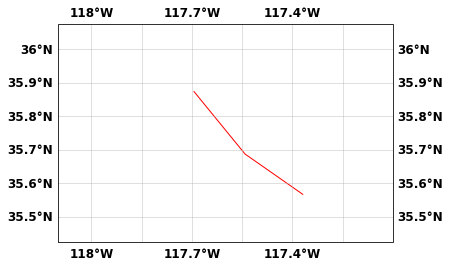

In [46]:
# View the fault trace
gp = geoplt(plotMinLon, plotMinLat, plotMaxLon, plotMaxLat, figure=1)
gp.faulttrace(fault, color='r')
gp.faultpatches(fault, slip='total')
gp.show(mapaxis='equal', showFig=['map'], fitOnBox=True) 

Now we are finally ready to start the downsampling of the interferogram. First we select only the pixels in the interferogram area with large coseismic deformation to be used for the downsampling with the `select_pixels` method, as parts far away won't be useful for constraining fault slip.

In [48]:
# select relevant area from data for downsampling
sar.select_pixels(minlon, maxlon, minlat, maxlat)

# check area of image after cropping
print ('cropped image area longitude {} to {}'.format(sar.lon.min(),sar.lon.max()))

cropped image area longitude 241.90041666666667 to 242.89958333333334


The fault downsampler and most other CSI classes are designed to work with a set of faults contained in a Python list object, so we need to make a list out of our one fault. In other situations, we could use multiple faults in the list.

In [49]:
faults = [fault]

We instantiate the image downsampling object with the SAR interferogram (could be optical offsets) and the set of faults. Then we initialize the downsampler with the `initialstate` method.

In [50]:
if do_downsample:
    downsampler = imagedownsampling('Downsampler', sar, faults=faults)
    downsampler.initialstate(8, 1, tolerance=0.05, plot=False, decimorig=10)

---------------------------------
---------------------------------
Initialize InSAR downsampling tools Downsampler
Effective pixel spacing: 0.0757734022125385


We can check some parameters to make sure the data is read in correctly.

In [51]:
    print ('ymin,ymax, boxll',downsampler.ymin,downsampler.ymax,downsampler.boxll)
    print ('original ALOS-2 D166 range',downsampler.image.vel.min(),downsampler.image.vel.max())

ymin,ymax, boxll 3906.0 4007.0 [[241.90041666666667, 35.30041666666666], [241.90041666666667, 36.19958333333333], [242.89958333333334, 36.19958333333333], [242.89958333333334, 35.30041666666666]]
original ALOS-2 D166 range -1.089601 1.142765


Now we can run the resolution-based downsampling (see Lohman and Simons (2005)).

In [52]:
    downsampler.resolutionBased(0.05, 0.009, slipdirection='s', plot=False, decimorig=10, verboseLevel='maximum', vertical=True)
    downsampler.writeDownsampled2File(prefix=outName+'_ifg', rsp=True)

---------------------------------
---------------------------------
Downsampling Iterations
Iteration 1: Testing 156 data samples 
 ===> Resolution from 8.824042750074458e-06 to 0.8151178443155244, Mean = 0.01724870029894701 +- 0.08815110581100631 
Iteration 2: Testing 183 data samples 
 ===> Resolution from 6.598256252812141e-06 to 0.8866329437644199, Mean = 0.03810253650938225 +- 0.1209593798796466 
Iteration 3: Testing 255 data samples 
 ===> Resolution from 4.932524494346197e-06 to 0.7685546060139854, Mean = 0.06735663520471893 +- 0.14343200673402148 
Iteration 4: Testing 465 data samples 
 ===> Resolution from 0.0 to 0.034872685230445725, Mean = 0.0016318101834848849 +- 0.005073498656641972 
 


Now the downsampling is completed, we can read in the set of decimated data that was saved to a file in the resampled `rsp` format. We instantiate another object from the same `insar` class as before, but we read from the variable resolution `varres` or `rsp` format file that contains the downsampled data values and the corners of the squares or quadtree areas that were averaged for each sample.

In [53]:
# read the decimated data back in
sardecim = insar('Decimated DataSet', utmzone=utmzone)
sardecim.read_from_varres(outName+'_ifg', factor=1.0, step=0.0)

---------------------------------
---------------------------------
Initialize InSAR data set Decimated DataSet
Read from file A2D166_ifg into data set Decimated DataSet


We can check that the dataset has the espected LOS vectors by plotting the LOS for each of the sampled points. In a regular python script, this will be an interactive 3D view.

Checks the LOS orientation


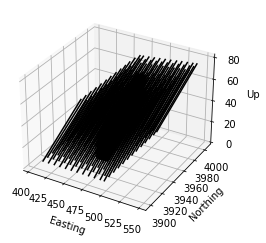

In [54]:
sardecim.checkLOS()  # plot direction of the LOS vectors

Now we can build the data covariance matrix `Cd` from the saved covariance function of distance and the distances between each of the sampled points using the `buildCovariaceMatrix` method. This method can also write the covariance matrix to a file with the same prefix as the downsampled ata so we can use it again without recalculating it.

In [55]:
# add covariance estimate
sardecim.Cd = covar.buildCovarianceMatrix(sardecim, 'Covariance estimator',write2file=outName+'_ifg.cov')

The data downsampling is complete. We can look at the results. This section is only activated if the `output_check` flag is true in case we don't need to see the plots. The first plot is the original dataset, and the second is the downsampled or decimated dataset.

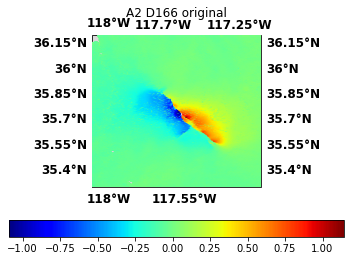

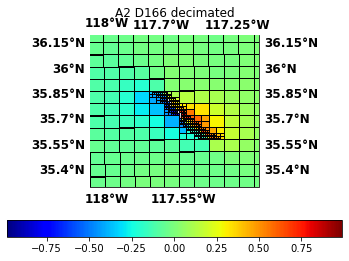

In [56]:
if output_check:
    gp = geoplt(figure=1,latmin=plotMinLat,lonmin=plotMinLon,latmax=plotMaxLat,lonmax=plotMaxLon)
    gp.drawCoastlines(parallels=0.2, meridians=0.2, drawOnFault=True, resolution='fine')
    gp.faulttrace(fault)
    gp.insar(sar,decim=10,plotType='scatter')
    gp.titlemap('A2 D166 original')
    gp.show(showFig=['map'])

    gp2 = geoplt(figure=3,latmin=plotMinLat,lonmin=plotMinLon,latmax=plotMaxLat,lonmax=plotMaxLon)
    gp2.drawCoastlines(parallels=0.2, meridians=0.2, drawOnFault=True, resolution='fine')
    gp2.faulttrace(fault)    
    gp2.insar(sardecim,data='data',plotType='decimate')
    gp2.titlemap('A2 D166 decimated')
    gp2.show(showFig=['map'])